# Assemble Model using DenseNet, EfficientNet, ResNet50, XGBoost, Light GBM, and CatBoost

## Here's datasets you will need
- train-image.hdf5
- train-metadata.csv
- augmented_data.hdf5
- augmented_metadata.csv
- isic_image.hdf5
- isic_metadata.csv
- test-image.hdf5
- test-metadata.csv
## Here's the models/paths you need to run without training the CNN model
- DenseNet121_checkpoints/DenseNet121_epoch_20.pth
- EfficientNet-B3_checkpoints/EfficientNet-B3_epoch_20.pth
- ResNet50_checkpoints/ResNet50_epoch_20.pth

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from dataset import HDF5Dataset
from sklearn.metrics import roc_auc_score, roc_curve
from isic_metric import score

## Data Loading

In [2]:
images = []
labels = []
metadata = []

### First, load all data from original database

In [3]:
original_train_hdf5_path = 'train-image.hdf5'
original_train_metadata_path = 'train-metadata.csv'
original_train_metadata = pd.read_csv(original_train_metadata_path,low_memory=False)   
original_train_hdf5 = h5py.File(original_train_hdf5_path, 'r')

In [4]:
for i in tqdm(range(len(original_train_metadata))):
    if original_train_metadata.iloc[i]['target'] == 0: 
        labels.append(0)
    else:
        labels.append(1)
    image_id = original_train_metadata.iloc[i]['isic_id']
    image = original_train_hdf5[image_id][()]
    image = np.frombuffer(image, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255
    images.append(image)
    metadata.append(original_train_metadata.iloc[i])
    
# original_train_hdf5.close()

100%|██████████| 401059/401059 [05:31<00:00, 1209.70it/s]


## Split data

In [6]:
# 60% training, 15% validation, 25% testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42)  # 0.625 * 0.4 = 0.25

# split metadata
metadata_train, metadata_temp = train_test_split(metadata, test_size=0.4, random_state=42)
metadata_val, metadata_test = train_test_split(metadata_temp, test_size=0.625, random_state=42)  # 0.625 * 0.4 = 0.25

## Add Augmented malignant images to training

In [ ]:
augmented_malignant_hdf5_path = 'augmented_data.hdf5'
augmented_malignant_metadata_path = 'augmented_metadata.csv'
augmented_malignant_metadata = pd.read_csv(augmented_malignant_metadata_path,low_memory=False)
augmented_malignant_hdf5 = h5py.File(augmented_malignant_hdf5_path, 'r')
n_augmentations = 5

In [ ]:
for i in tqdm(range(len(augmented_malignant_metadata))):
    image_id = f"{augmented_malignant_metadata.iloc[i]['isic_id']}"
    image = augmented_malignant_hdf5[image_id][()]
    image = np.frombuffer(image, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255
    X_train.append(image)
    y_train.append(1)
    metadata_train.append(augmented_malignant_metadata.iloc[i])
    
augmented_malignant_hdf5.close()

In [ ]:
print(len(X_train))

## Add ISIC malignant data to training

In [ ]:
isic_metadata_path = 'isic_metadata.csv'
isic_hdf5_path = 'isic_image.hdf5'
isic_metadata = pd.read_csv(isic_metadata_path,low_memory=False)
isic_hdf5 = h5py.File(isic_hdf5_path, 'r')

In [ ]:
for i in tqdm(range(len(isic_metadata))):
    if isic_metadata.iloc[i]['benign_malignant'] != 'malignant': 
        continue
    image_id = isic_metadata.iloc[i]['isic_id']
    image = isic_hdf5[image_id][()]
    image = np.frombuffer(image, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255
    
    X_train.append(image)
    y_train.append(1)
    metadata_train.append(isic_metadata.iloc[i])
isic_hdf5.close()

## Balance the training set

In [ ]:
# balance X_train and y_train so that they have the same number of benign and malignant samples
X_train = np.array(X_train)
y_train = np.array(y_train)
metadata_train = pd.DataFrame(metadata_train)

malignant_indices = np.where(y_train == 1)[0]
benign_indices = np.where(y_train == 0)[0]
benign_indices = np.random.choice(benign_indices, len(malignant_indices), replace=False)
balanced_indices = np.concatenate([malignant_indices, benign_indices])
np.random.shuffle(balanced_indices)
X_train = X_train[balanced_indices]
y_train = y_train[balanced_indices]
metadata_train = metadata_train.iloc[balanced_indices].reset_index(drop=True)

In [ ]:
print(f'Training data: {len(X_train)}')
print(f'Validation data: {len(X_val)}')
print(f'Test data: {len(X_test)}')
print(f'Metadata Training data: {len(metadata_train)}')
print(f'Metadata Validation data: {len(metadata_val)}')
print(f'Metadata Test data: {len(metadata_test)}')

## Load CNN models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### DenseNet

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights
from ModelTrainer import Trainer
densenet_weights = DenseNet121_Weights.DEFAULT
densenet_transform = densenet_weights.transforms()
densenet_train_dataset = HDF5Dataset(X_train, y_train, augment=True, transform=densenet_transform)
densenet_val_dataset = HDF5Dataset(X_val, y_val, augment=False, transform=densenet_transform)
densenet_model = densenet121(weights=densenet_weights)
lr = 1e-5
num_epochs = 20
dense_net_trainer = Trainer(device, densenet_train_dataset, densenet_val_dataset, "DenseNet121", densenet_weights, densenet_transform, densenet_model, lr, num_epochs)

Validation: 100%|██████████| 940/940 [02:50<00:00,  5.51it/s]


Epoch 1: Acc = 0.9915, Precision = 0.0308, Recall = 0.2778, F1 = 0.0555, pAUC = 0.1085


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.19it/s]


Epoch 2: Acc = 0.9950, Precision = 0.0446, Recall = 0.2222, F1 = 0.0743, pAUC = 0.1203


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.19it/s]


Epoch 3: Acc = 0.9968, Precision = 0.0683, Recall = 0.2037, F1 = 0.1023, pAUC = 0.1186


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.20it/s]


Epoch 4: Acc = 0.9870, Precision = 0.0222, Recall = 0.3148, F1 = 0.0415, pAUC = 0.1180


Validation: 100%|██████████| 940/940 [02:32<00:00,  6.15it/s]


Epoch 5: Acc = 0.9956, Precision = 0.0517, Recall = 0.2222, F1 = 0.0839, pAUC = 0.1122


Validation: 100%|██████████| 940/940 [02:32<00:00,  6.16it/s]


Epoch 6: Acc = 0.9930, Precision = 0.0356, Recall = 0.2593, F1 = 0.0626, pAUC = 0.0918


Validation: 100%|██████████| 940/940 [02:32<00:00,  6.15it/s]


Epoch 7: Acc = 0.9968, Precision = 0.0629, Recall = 0.1852, F1 = 0.0939, pAUC = 0.0914


Validation: 100%|██████████| 940/940 [02:32<00:00,  6.18it/s]


Epoch 8: Acc = 0.9929, Precision = 0.0461, Recall = 0.3519, F1 = 0.0815, pAUC = 0.1018


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.18it/s]


Epoch 9: Acc = 0.9885, Precision = 0.0296, Recall = 0.3704, F1 = 0.0548, pAUC = 0.1013


Validation: 100%|██████████| 940/940 [02:32<00:00,  6.17it/s]


Epoch 10: Acc = 0.9936, Precision = 0.0418, Recall = 0.2778, F1 = 0.0726, pAUC = 0.0956


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.20it/s]


Epoch 11: Acc = 0.9910, Precision = 0.0381, Recall = 0.3704, F1 = 0.0691, pAUC = 0.0973


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.21it/s]


Epoch 12: Acc = 0.9913, Precision = 0.0282, Recall = 0.2593, F1 = 0.0508, pAUC = 0.0994


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.19it/s]


Epoch 13: Acc = 0.9952, Precision = 0.0498, Recall = 0.2407, F1 = 0.0825, pAUC = 0.0812


Validation: 100%|██████████| 940/940 [02:30<00:00,  6.24it/s]


Epoch 14: Acc = 0.9948, Precision = 0.0515, Recall = 0.2778, F1 = 0.0870, pAUC = 0.0633


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.22it/s]


Epoch 15: Acc = 0.9873, Precision = 0.0241, Recall = 0.3333, F1 = 0.0449, pAUC = 0.1010


Validation: 100%|██████████| 940/940 [02:30<00:00,  6.24it/s]


Epoch 16: Acc = 0.9906, Precision = 0.0311, Recall = 0.3148, F1 = 0.0566, pAUC = 0.0874


Validation: 100%|██████████| 940/940 [02:32<00:00,  6.18it/s]


Epoch 17: Acc = 0.9919, Precision = 0.0382, Recall = 0.3333, F1 = 0.0686, pAUC = 0.0967


Validation: 100%|██████████| 940/940 [02:33<00:00,  6.14it/s]


Epoch 18: Acc = 0.9913, Precision = 0.0302, Recall = 0.2778, F1 = 0.0544, pAUC = 0.0759


Validation: 100%|██████████| 940/940 [02:31<00:00,  6.20it/s]


Epoch 19: Acc = 0.9963, Precision = 0.0615, Recall = 0.2222, F1 = 0.0964, pAUC = 0.0528


Validation: 100%|██████████| 940/940 [02:32<00:00,  6.16it/s]


Epoch 20: Acc = 0.9924, Precision = 0.0449, Recall = 0.3704, F1 = 0.0802, pAUC = 0.0846


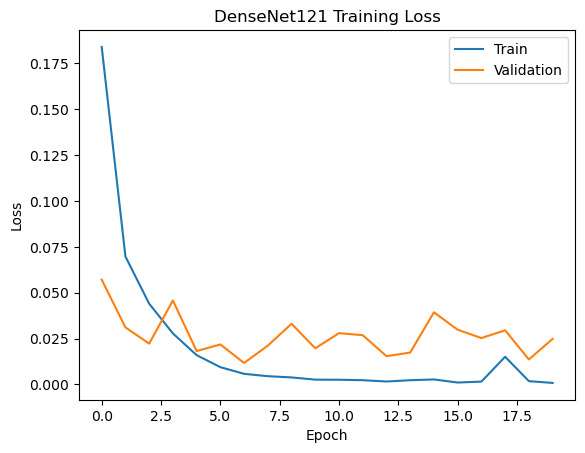

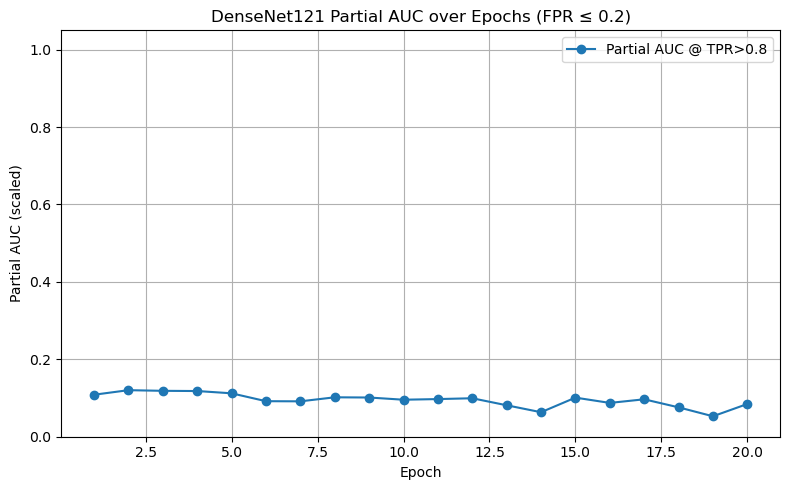

In [15]:
# dense_net_trainer.train()

### Load model if already trained and calculate pAUC

In [16]:
# densenet_model_path = "DenseNet121_checkpoints/DenseNet121_epoch_20.pth"
# densenet_checkpoint = torch.load(densenet_model_path, weights_only=False, map_location=device)
# dense_net_trainer.model.load_state_dict(densenet_checkpoint['model_state_dict'])

### Calculate test pAUC 

In [ ]:
from calc_pauc import pAUC
dense_net_trainer.model.eval()
calc_pAUC = pAUC(device, dense_net_trainer.model, dense_net_trainer.transform, X_test, y_test,  metadata_test)
calc_pAUC.compute_pAUC()

## EfficientNet

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
efficientnet_weights = EfficientNet_B3_Weights.DEFAULT
efficientnet_transform = efficientnet_weights.transforms()
efficientnet_train_dataset = HDF5Dataset(X_train, y_train, augment=True, transform=efficientnet_transform)
efficientnet_val_dataset = HDF5Dataset(X_val, y_val, augment=False, transform=efficientnet_transform)
efficientnet_model = efficientnet_b3(weights=efficientnet_weights)
lr = 3e-5
num_epochs = 20
efficientnet_trainer = Trainer(device, efficientnet_train_dataset, efficientnet_val_dataset, "EfficientNet-B3", efficientnet_weights, efficientnet_transform, efficientnet_model, lr, num_epochs)

In [ ]:
# efficientnet_trainer.train()

### Load EfficientNet Model if already trained and compute pAUC

In [ ]:
efficientnet_model_path = "EfficientNet-B3_checkpoints/EfficientNet-B3_epoch_18.pth"
efficientnet_checkpoint = torch.load(efficientnet_model_path, weights_only=False, map_location=device)
efficientnet_model.load_state_dict(efficientnet_checkpoint['model_state_dict'])

### pAUC calculation

In [ ]:
efficientnet_model.eval()
calc_pAUC = pAUC(device, efficientnet_trainer.model, efficientnet_trainer.transform, X_test, y_test,  metadata_test)
calc_pAUC.compute_pAUC()

## ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

resnet_weights = ResNet50_Weights.DEFAULT
resnet_transform = resnet_weights.transforms()

resnet_train_dataset = HDF5Dataset(X_train, y_train, transform=resnet_transform)
resnet_val_dataset = HDF5Dataset(X_val, y_val, transform=resnet_transform)
resnet_model = resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)

lr = 4e-5
num_epochs = 20
resnet_trainer = Trainer(device, resnet_train_dataset, resnet_val_dataset, "ResNet50", resnet_weights, resnet_transform, resnet_model, lr, num_epochs)

In [ ]:
resnet_trainer.train()

### Load ResNet50 if already trained and calculate pAUC

In [ ]:
# resnet_model_path = "ResNet50_checkpoints/ResNet50_epoch_20.pth"
# resnet_checkpoint = torch.load(resnet_model_path, weights_only=False, map_location=device)
# resnet_trainer.model.load_state_dict(resnet_checkpoint['model_state_dict'])

### pAUC Calculation

In [ ]:
resnet_model.eval()
calc_pAUC = pAUC(device, resnet_trainer.model, resnet_trainer.transform, X_test, y_test,  metadata_test)
calc_pAUC.compute_pAUC()

## Output predictions for train/val/test for all CNN models

#### Convert CNNs's output predictions

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch.nn.functional as F
from PIL import Image

class TorchCNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device='cpu', transform=None, threshold=0.5):
        self.model = model.eval().to(device)
        self.device = device
        self.transform = transform
        self.threshold = threshold

    def _prepare_image(self, img):
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)
        return self.transform(img).unsqueeze(0).to(self.device)

    def predict_proba(self, X):
        self.model.eval()
        probs = []
    
        with torch.no_grad():
            for img in tqdm(X, desc="Predicting with CNN"):
                img_tensor = self._prepare_image(img)
                logits = self.model(img_tensor)
                prob = torch.sigmoid(logits).cpu().item()
                probs.append(prob)
                # probs.append([1 - prob, prob])
    
        return probs

    # def predict(self, X):
    #     probs = self.predict_proba(X)
        
    #     # return (probs[:, 1] >= self.threshold).astype(int)

### Convert model into essemble model compatible format

In [ ]:
densenet_wrapper = TorchCNNWrapper(
    model=dense_net_trainer.model,
    device=device,
    transform=dense_net_trainer.transform
)

efficientnet_wrapper = TorchCNNWrapper(
    model=efficientnet_trainer.model,
    device=device,
    transform=efficientnet_trainer.transform
)

resnet_wrapper = TorchCNNWrapper(
    model=resnet_trainer.model,
    device=device,
    transform=resnet_trainer.transform
)

In [ ]:
# generate predictions for training set
densenet_train_preds = densenet_wrapper.predict_proba(X_train)
efficientnet_train_preds = efficientnet_wrapper.predict_proba(X_train)
resnet_train_preds = resnet_wrapper.predict_proba(X_train)

In [ ]:
# generate predictions for validation set
densenet_val_preds = densenet_wrapper.predict_proba(X_val)
efficientnet_val_preds = efficientnet_wrapper.predict_proba(X_val)
resnet_val_preds = resnet_wrapper.predict_proba(X_val)

In [ ]:
# generate predictions for test set
densenet_test_preds = densenet_wrapper.predict_proba(X_test)
efficientnet_test_preds = efficientnet_wrapper.predict_proba(X_test)
resnet_test_preds = resnet_wrapper.predict_proba(X_test)

In [ ]:
# train predictions
train_preds = pd.concat([
    pd.Series([row['isic_id'] for row in metadata_train], name="isic_id"),
    pd.Series(densenet_train_preds, name="densenet"),
    pd.Series(efficientnet_train_preds, name="efficientnet"),
    pd.Series(resnet_train_preds, name="resnet"),
    pd.Series(y_train, name="GroundTruth")
], axis=1)

In [ ]:
# use pd concat to combine the predictions
val_preds = pd.concat([
    pd.Series([row['isic_id'] for row in metadata_val], name="isic_id"),
    pd.Series(densenet_val_preds, name="densenet"),
    pd.Series(efficientnet_val_preds, name="efficientnet"),
    pd.Series(resnet_val_preds, name="resnet"),
    pd.Series(y_val, name="GroundTruth")
], axis=1)

In [ ]:
# use pd concat to combine the predictions
test_preds = pd.concat([
    pd.Series([row['isic_id'] for row in metadata_test], name="isic_id"),
    pd.Series(densenet_test_preds, name="densenet"),
    pd.Series(efficientnet_test_preds, name="efficientnet"),
    pd.Series(resnet_test_preds, name="resnet"),
    pd.Series(y_test, name="GroundTruth")
], axis=1)

In [ ]:
train_preds.to_csv("train_predictions.csv", index=False)

In [ ]:
# save the predictions to csv
val_preds.to_csv("val_predictions.csv", index=False)
test_preds.to_csv("test_predictions.csv", index=False)

## Load Tree based models

In [ ]:
idx

### XGBoost

### Light GBM

### CatBoost